In [1]:
import cv2
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt


In [2]:
# Load FITS file
hdu_list = fits.open(r"C:\Users\avsk1\OneDrive\Desktop\coding\more code\Synthetic Streaks\noisy_synthetic_fma_streak_01.fits")
image_data = hdu_list[0].data

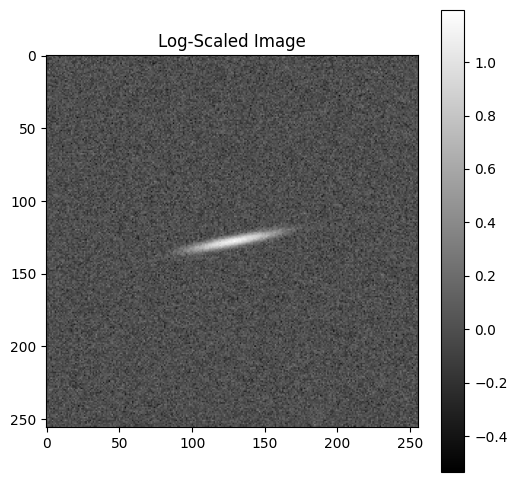

In [3]:
# Step 1: Preprocess the image (apply log scaling)
image_data_log = np.log(image_data + 1)  # Add 1 to avoid log(0)

# Display the log-scaled image
plt.figure(figsize=(6, 6))
plt.imshow(image_data_log, cmap='gray')
plt.title("Log-Scaled Image")
plt.colorbar()
plt.show()

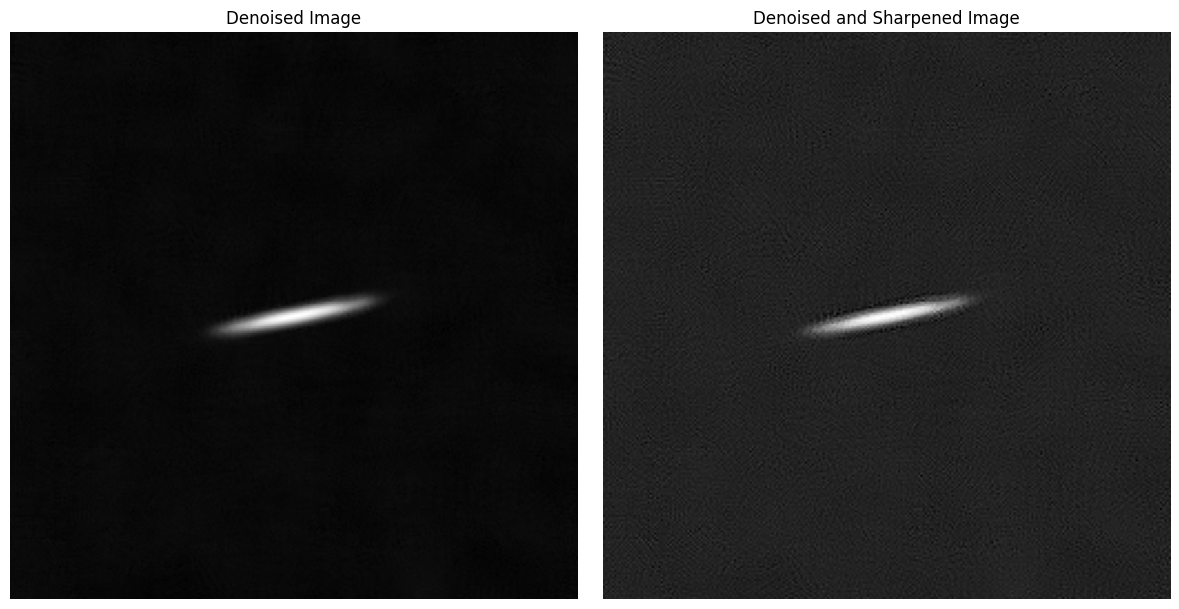

In [4]:
# Step 1: Normalize the image to 8-bit
image_data_8bit = cv2.normalize(image_data_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Step 2: Denoise the image using Non-Local Means Denoising
denoised_image = cv2.fastNlMeansDenoising(image_data_8bit, None, h=15, templateWindowSize=7, searchWindowSize=21)

# Step 3: Sharpen the denoised image
# Define a sharpening kernel
sharpening_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])

# Apply the sharpening filter
sharpened_image = cv2.filter2D(denoised_image, -1, sharpening_kernel)

# Display the denoised and sharpened image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Denoised and Sharpened Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Step 3: Normalize image for edge detection
normalized_image = cv2.normalize(denoised_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


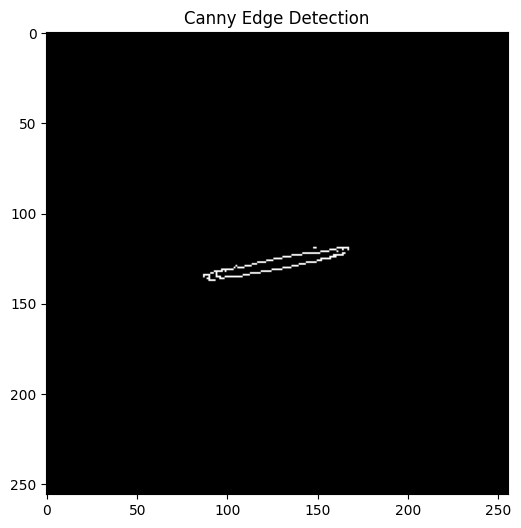

In [6]:
# Step 4: Apply Canny edge detection
edges = cv2.Canny(normalized_image, threshold1=50, threshold2=150)

# Display the edges
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.show()


In [7]:
# Step 5: Morphological operations to enhance streaks
# Define a kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Apply dilation followed by erosion (closing operation)
morphological_mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

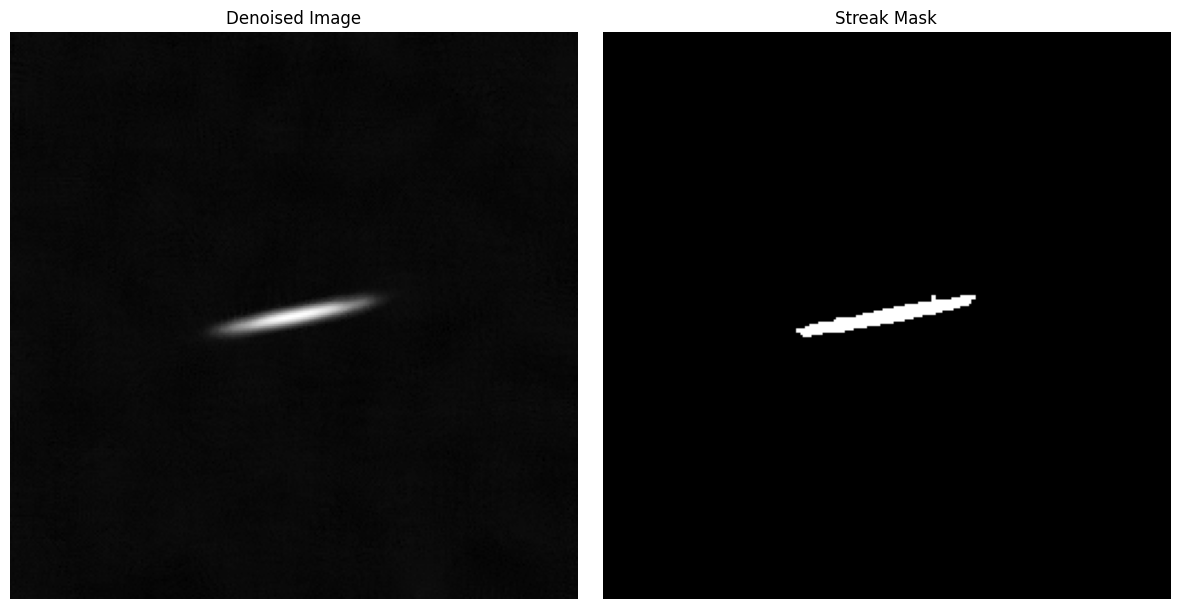

In [8]:
# Step 6: Create a mask for detected streaks
streak_mask = np.zeros_like(denoised_image)

# Find contours in the morphological mask
contours, _ = cv2.findContours(morphological_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the streak mask
for contour in contours:
    cv2.drawContours(streak_mask, [contour], -1, (255), thickness=cv2.FILLED)

# Display the denoised image and the streak mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(streak_mask, cmap='gray')
plt.title("Streak Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

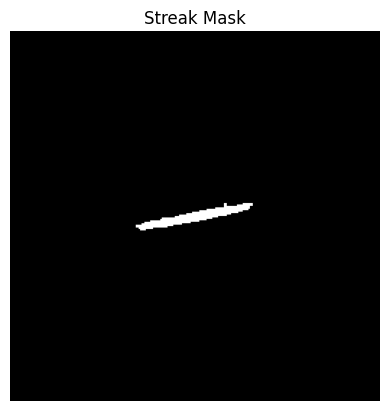

In [9]:
plt.imshow(streak_mask, cmap='gray')
plt.title("Streak Mask")
plt.axis('off')

plt.show

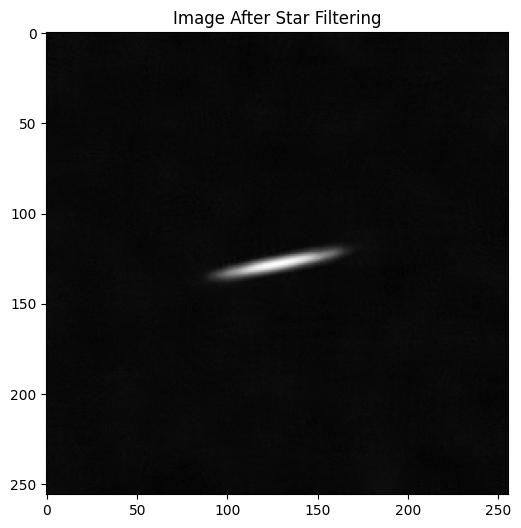

In [10]:
# Step 5: Find contours (for detecting stars and streaks)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Filter out round objects (stars) based on circularity
filtered_image = np.copy(normalized_image)
for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if perimeter > 0:
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        if 0.7 <= circularity <= 1.2:  # Tweak these values based on your dataset
            cv2.drawContours(filtered_image, [contour], -1, (0, 0, 0), -1)  # Fill the star with black

# Display the filtered image (stars removed)
plt.figure(figsize=(6, 6))
plt.imshow(filtered_image, cmap='gray')
plt.title("Image After Star Filtering")
plt.show()

In [11]:
# Step 7: Apply Hough Line Transform to detect streaks (after filtering stars)
edges_filtered = cv2.Canny(streak_mask, threshold1=50, threshold2=150)
lines = cv2.HoughLinesP(edges_filtered, rho=3, theta=np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

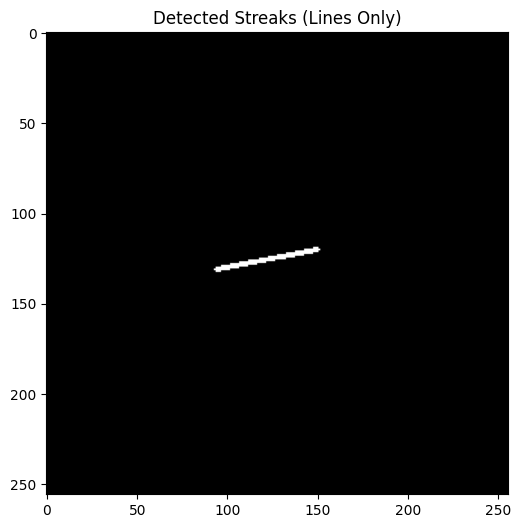

In [12]:

# Step 8: Draw detected lines on a blank image
longest_line = None
max_length = 0

# Create a blank image for drawing lines
line_image = np.zeros_like(normalized_image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        if length > max_length:
            max_length = length
            longest_line = line
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in red

    # Highlight the longest line in blue
    if longest_line is not None:
        x1, y1, x2, y2 = longest_line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Draw the longest line in blue and thicker

# Display the image with detected streaks (after star filtering)
plt.figure(figsize=(6, 6))
plt.imshow(line_image, cmap='gray')
plt.title("Detected Streaks (Lines Only)")
plt.show()

In [13]:
# Save the generated line fit
plt.imsave(r"C:\Users\avsk1\OneDrive\Desktop\coding\more code\Hough Lines\hough_lines_04.png",line_image, cmap='gray')


In [14]:
# Print the endpoints of the longest line
if longest_line is not None:
    x1, y1, x2, y2 = longest_line[0]
    print("Endpoints of the longest line: ({}, {}), ({}, {})".format(x1, y1, x2, y2))

Endpoints of the longest line: (94, 137), (161, 124)


In [15]:
# Close the FITS file
hdu_list.close()